This is a challenge project for TDI semifinalist challenge.

The Employee Reviews dataset is from kaggle: 
https://www.kaggle.com/petersunga/google-amazon-facebook-employee-reviews/version/2

idea: 'There is no loser in the world, only winner in the wrong place.'

The movitation of this project is to: recommend companies to employee. The benefit for employee is that they can work for the company they real like. For the employee aspect, they can have stable employee.

Business Plan: charged for companies

<ul>
<li>[Step 1: Data Analysis for rating score](#Part-1:-Rating-Analysis)
<li>[Step 2: TF-IDF for extracting significant keyword](#Part-2:-Review-Analysis)
<li>[Step 3: Recommendation System for matching ideal company for employee](#Part-3:-Recommendation)
</ul>

In [1]:
# Load Data
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)

df = pd.read_csv(r'C:\Users\liudi\Desktop\python code\LaiData_MLProjects\TDI\employee_reviews.csv')
df.head()

,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
0,1,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,none,5.0,4.0,5.0,5.0,4.0,5.0,0,https://www.glassdoor.com/Reviews/Google-Revie...
1,2,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,4.0,2.0,3.0,3.0,5.0,3.0,2094,https://www.glassdoor.com/Reviews/Google-Revie...
2,3,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,5.0,4.0,5.0,5.0,4.0,949,https://www.glassdoor.com/Reviews/Google-Revie...
3,4,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5.0,2.0,5.0,5.0,4.0,5.0,498,https://www.glassdoor.com/Reviews/Google-Revie...
4,5,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5.0,5.0,5.0,5.0,5.0,5.0,49,https://www.glassdoor.com/Reviews/Google-Revie...


In [2]:
print('The dimension of the table is ' + str(df.shape[0]) + ' rows and ' + str(df.shape[1]) + ' columns.')  

The dimension of the table is 67529 rows and 17 columns.


In [3]:
# convert 'object' type data into 'float' type data
df['work-balance-stars']=pd.to_numeric(df['work-balance-stars'],errors='coerce')
df['culture-values-stars']=pd.to_numeric(df['culture-values-stars'],errors='coerce')
df['carrer-opportunities-stars']=pd.to_numeric(df['carrer-opportunities-stars'],errors='coerce')
df['comp-benefit-stars']=pd.to_numeric(df['comp-benefit-stars'],errors='coerce')
df['senior-mangemnet-stars']=pd.to_numeric(df['senior-mangemnet-stars'],errors='coerce')

# Part 1: Rating Analysis

### factors related most to the overall ratings

In [4]:
corr_list=[]
for key in dict(df.dtypes):
    if dict(df.dtypes)[key] == 'float64':
        corr_list.append(key)

corr = df[corr_list].corr()
corr.head()

,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars
overall-ratings,1.000000,0.609253,0.758462,0.692263,0.537515,0.726001
work-balance-stars,0.609253,1.000000,0.573674,0.462895,0.416517,0.571932
culture-values-stars,0.758462,0.573674,1.000000,0.584871,0.462756,0.715195
carrer-opportunities-stars,0.692263,0.462895,0.584871,1.000000,0.511943,0.631258
comp-benefit-stars,0.537515,0.416517,0.462756,0.511943,1.000000,0.470887


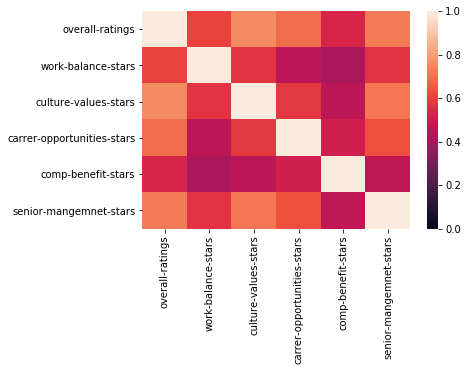

In [5]:
% matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sb

sb.heatmap(corr,vmin=0, vmax=1)

# Part 2: Review Analysis

#### 2.1 Seperate dataframe according to company

In [6]:
g = df.groupby('company').size()
g.head()

company
amazon       26430
apple        12950
facebook      1590
google        7819
microsoft    17930
dtype: int64

In [7]:
df_google=df.loc[df['company'] == 'google']
df_amazon=df.loc[df['company'] == 'amazon']
df_apple=df.loc[df['company'] == 'apple']
df_facebook=df.loc[df['company'] == 'facebook']
df_microsoft=df.loc[df['company'] == 'microsoft']

#### 2.2 Get the 'pros' comment into list

In [8]:
def get_pros(df_company):
    pros = []
    for i in range(len(df_company)):  
        pros.append(df_company.iloc[i][6])
    return pros

amazon_pros = get_pros(df_amazon)
google_pros = get_pros(df_google)
apple_pros = get_pros(df_apple)
facebook_pros = get_pros(df_facebook)
microsoft_pros = get_pros(df_microsoft)

In [9]:
print(len(amazon_pros),len(google_pros),len(apple_pros),len(facebook_pros),len(microsoft_pros))

26430 7819 12950 1590 17930


#### 2.3 Tokenize the words

In [10]:
import nltk
import re

# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')

In [11]:
def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [12]:
def get_docs_tokenized(company_pros):
    docs_tokenized = []
    for i in company_pros:  # company    
        tokenized_results = tokenization(i)
        docs_tokenized.extend(tokenized_results)
    return docs_tokenized

amazon_docs_tokenized = get_docs_tokenized(amazon_pros)
google_docs_tokenized = get_docs_tokenized(google_pros)
facebook_docs_tokenized = get_docs_tokenized(facebook_pros)
apple_docs_tokenized = get_docs_tokenized(apple_pros)
microsoft_tokenized = get_docs_tokenized(microsoft_pros)
all_docs_tokenized = list(set().union(amazon_docs_tokenized,google_docs_tokenized,facebook_docs_tokenized,\
                                      apple_docs_tokenized,microsoft_tokenized))

#### 2.4 TF-IDF to get most significant words

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(max_df=1.0, max_features=100,
                                 min_df=0.05, stop_words='english',
                                 use_idf=True, tokenizer=tokenization, ngram_range=(1,1))

def get_feature_words(company_pros):
    tfidf_matrix = tfidf_model.fit_transform(company_pros) # company 

    print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
          " comments and " + str(tfidf_matrix.shape[1]) + " terms.")
    
    tf_selected_words = tfidf_model.get_feature_names()
    return tf_selected_words

amazon_feature_word = get_feature_words(amazon_pros)
google_feature_word = get_feature_words(google_pros)
facebook_feature_word = get_feature_words(facebook_pros)
apple_feature_word = get_feature_words(apple_pros)
microsoft_feature_word = get_feature_words(microsoft_pros)  

In total, there are 26430 comments and 27 terms.
In total, there are 7819 comments and 28 terms.
In total, there are 1590 comments and 51 terms.
In total, there are 12950 comments and 28 terms.
In total, there are 17930 comments and 29 terms.


#### 2.5 Plot wordcloud

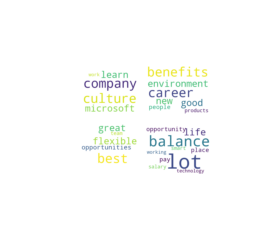

In [14]:
amazon_text = ' '.join(amazon_feature_word)
google_text = ' '.join(google_feature_word)
facebook_text = ' '.join(facebook_feature_word)
apple_text = ' '.join(apple_feature_word)
microsoft_text = ' '.join(microsoft_feature_word)

% matplotlib inline 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy.misc import imread
mask = imread(r'C:\Users\liudi\Desktop\mask3.png')
wc=WordCloud(mask=mask,background_color="white",scale=2).generate(microsoft_text)

plt.imshow(wc,interpolation='bilinear')
plt.axis("off")
plt.show()

wc.to_file(r'C:\Users\liudi\Desktop\test.jpg')

# Part 3: Recommendation

In [15]:
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XFTH0UtKhww
# https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/
# https://stackoverflow.com/questions/22129943/how-to-calculate-the-sentence-similarity-using-word2vec-model-of-gensim-with-pyt
import gensim 
from gensim.models import Word2Vec
from numpy  import array
a=array(all_docs_tokenized)
wv_model= Word2Vec(a.reshape(-1, 1), min_count=1)
vocabulary = wv_model.wv.vocab

In [16]:
def get_featureVec(company_feature_word):
    featureVec = np.ones((100,), dtype="float32")
    nwords = 0
    for word in company_feature_word:
        if word in vocabulary.keys():
            nwords = nwords+1
            featureVec = np.add(featureVec, wv_model[word])
        if(nwords>0):
            featureVec = np.divide(featureVec, nwords)
    return featureVec

amazon_featureVec = get_featureVec(amazon_feature_word)
google_featureVec = get_featureVec(google_feature_word)
facebook_featureVec = get_featureVec(facebook_feature_word)
apple_featureVec = get_featureVec(apple_feature_word)
microsoft_featureVec = get_featureVec(microsoft_feature_word)
featureVec_list = [amazon_featureVec,google_featureVec,facebook_featureVec,apple_featureVec,microsoft_featureVec]

In [17]:
user_input = ['benefit','culture', 'opportunity', 'smart', 'people', 'team', 'working']
#user_input = ['pay', 'opportunity','culture','smart','balance', 'right']
featureVec1 = np.ones((100,), dtype="float32")
nwords = 0
for word in user_input:
    if word in vocabulary.keys():
        nwords = nwords+1
        featureVec1 = np.add(featureVec1, wv_model[word])
    if(nwords>0):
        featureVec1 = np.divide(featureVec1, nwords)
#print(featureVec1) 

In [18]:
from scipy import spatial
def get_recommend_company(lst,input_vec):
    company_name = ['Amazon', 'Google', 'Facebook', 'Apple', 'Microsoft']
    i = 0
    dict_vec = {}
    for featureVec in featureVec_list:
        sim = 1 - spatial.distance.cosine(featureVec,input_vec)
        sim = round(sim,10)
        dict_vec[sim]=company_name[i]
        i = i+1
        print(dict_vec.keys())
    return dict_vec

vec=get_recommend_company(featureVec_list,featureVec1)

dict_keys([0.8998115659])
dict_keys([0.8998115659, 0.8997105956])
dict_keys([0.8998115659, 0.8997105956, 0.1876531094])
dict_keys([0.8998115659, 0.8997105956, 0.1876531094, 0.8998474479])
dict_keys([0.8998115659, 0.8997105956, 0.1876531094, 0.8998474479, 0.8997023106])


In [19]:
print('The most recommended company is: ' + vec[max(vec.keys())])

The most recommended company is: Apple
